In [44]:
import os 
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
from datetime import datetime
import itertools
from sklearn.cluster import MiniBatchKMeans
from scipy.signal import detrend
from arch import arch_model
import numpy as np
from scipy import signal, fft

DIR = os.path.join(os.path.dirname(os.getcwd()), "img")
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
DPI = 300
OBS_THRESH = 240
AS_OF_DATE = datetime(2024, 12, 31)
MCAP_THRESH = 300000

signals = ['b2m', 'c2p', 's2p', 'e2p', 'mom_12_1', 'mom_6_1', 'resid_mom']  # , 'strev'
signal_grouping = {
    "Value": ['b2m', 'c2p', 's2p', 'e2p'],
    "Momentum/Reversion": ['mom_12_1', 'mom_6_1', 'resid_mom', 'strev'],
}

In [3]:
raw_signals = pd.read_pickle(f"{DATA_DIR}/raw_signals.pkl")
crsp = pd.read_pickle(f"{DATA_DIR}/crsp.pkl")

## I should create a table with the wave length of each signal

In [ ]:
# Sample stocks
active_flags = crsp.xs(AS_OF_DATE).all(axis=1)  # Filter 1: active stocks
mcap = crsp['shrout'].mul(crsp['prc'].abs()).xs(AS_OF_DATE, level='date')
mcap_flags = (mcap >= MCAP_THRESH).reindex(mcap.index).fillna(False)  # Filter 2: remove micro-caps
length_flags = (raw_signals.groupby("permno").count() > OBS_THRESH).all(axis=1)  # Filter 3: enough observations
sample_flags = pd.concat([active_flags, mcap_flags, length_flags], axis=1).all(axis=1)  # Put together the flags
sample_ids = sample_flags[sample_flags].index
print(len(sample_ids))

1752


<Axes: title={'center': 'Number of stocks with market cap > 300,000'}, xlabel='date'>

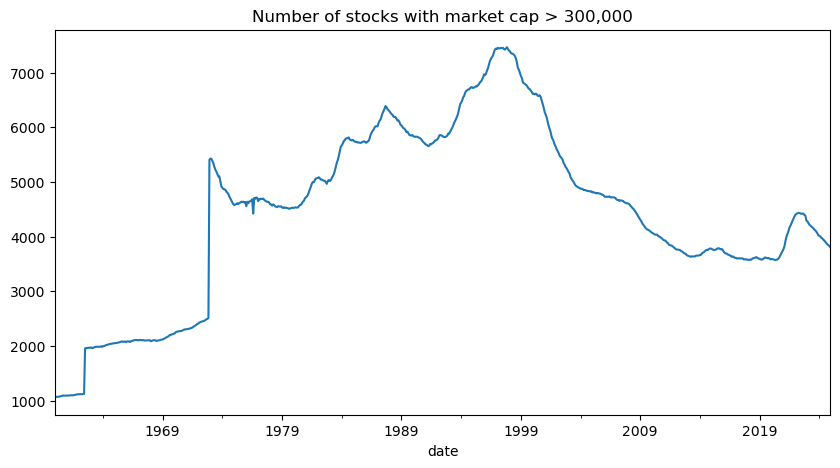

In [105]:
mcap.count(axis=1).plot(title="Number of stocks with market cap > 300,000", figsize=(10, 5))

<Axes: title={'center': 'Number of stocks with market cap > 3,000'}, xlabel='date'>

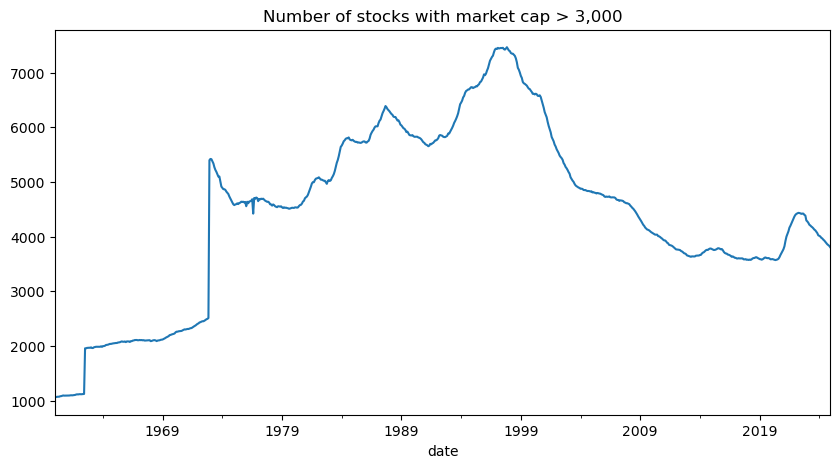

In [125]:
(mcap > 1).sum(axis=1).plot(title="Number of stocks with market cap > 3,000", figsize=(10, 5))

# Standardize on a cross-sectional basis, I don't really need to do this longitudinally

In [ ]:
mcap.xs("")

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93423,93426,93428,93429,93430,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1960-01-31,NaN,NaN,NaN,NaN,NaN,69127.50,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02-29,NaN,NaN,NaN,NaN,NaN,71431.75,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03-31,NaN,NaN,NaN,NaN,NaN,67177.75,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04-30,NaN,NaN,NaN,NaN,NaN,61683.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05-31,NaN,NaN,NaN,NaN,NaN,63810.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,337725.52,NaN,2.149182e+07,NaN,NaN,NaN,11975.2853,NaN,6.840044e+08
2024-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,316808.80,NaN,2.143637e+07,NaN,NaN,NaN,8024.9300,NaN,8.390474e+08
2024-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,283904.72,NaN,2.234668e+07,NaN,NaN,NaN,5253.2000,NaN,8.020335e+08


In [123]:
mcap.apply(np.nanpercentile, args=(20,), axis=1)

date
1960-01-31    19630.00000
1960-02-29    19546.40000
1960-03-31    18850.50000
1960-04-30    18592.05000
1960-05-31    18787.75000
                 ...     
2024-08-31    55875.47000
2024-09-30    57425.00000
2024-10-31    59049.88200
2024-11-30    61261.74000
2024-12-31    64234.03678
Length: 780, dtype: float64

In [115]:
mcap.apply(lambda x: x.quantile(.05), axis=1)

date
1960-01-31    6869.250000
1960-02-29    6927.825000
1960-03-31    6715.500000
1960-04-30    6256.500000
1960-05-31    6163.750000
                 ...     
2024-08-31    6623.092765
2024-09-30    6568.077000
2024-10-31    6475.304000
2024-11-30    6548.707740
2024-12-31    6815.558000
Length: 780, dtype: float64

In [97]:
mcap = crsp['shrout'].mul(crsp['prc'].abs()).unstack().astype(float)
(mcap > mcap.apply(np.nanpercentile, args=(15,), axis=1)).count(axis=1)

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

In [5]:
for sec_ids, sgnl in itertools.product(sample_ids, signals):
    pass

<Axes: >

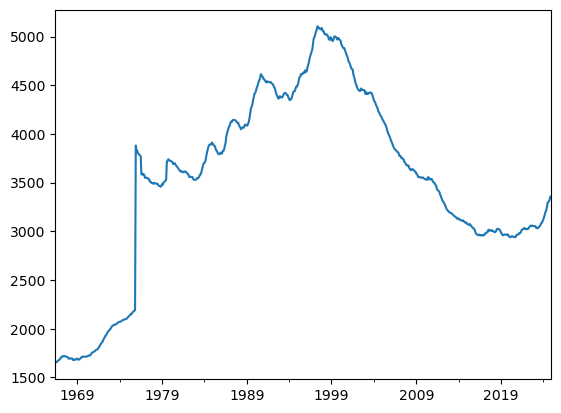

In [76]:
X = raw_signals[sgnl].unstack().dropna(how="all")
X.count(axis=1).plot()

In [78]:
mcap

permno
10026        3021622.14
10028         186651.28
10032        4239356.16
10044          18463.14
10066           57741.6
              ...      
93397         441087.18
93426         286709.52
93429    20455643.35314
93434          18249.16
93436      1296350630.4
Length: 3806, dtype: Float64

permno,10006.0,10014.0,10030.0,10057.0,10102.0,10137.0,10145.0,10153.0,10161.0,10188.0,...,25819.0,25820.0,25861.0,25886.0,25916.0,25977.0,25978.0,25980.0,26003.0,26037.0
1966-06-30,0.056006,0.175748,-0.029219,0.045986,-0.024746,-0.071801,-0.124072,0.04765,-0.020225,-0.084014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966-07-31,0.157637,0.209161,-0.012192,-0.000983,-0.049449,-0.080494,-0.060897,0.010836,-0.076364,-0.231599,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966-08-31,0.123917,0.188376,0.040996,0.102775,-0.120173,-0.057573,-0.087852,0.022023,-0.144842,-0.173524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966-09-30,0.098864,0.192104,-0.067221,-0.063421,-0.088502,-0.081897,-0.046104,-0.046816,-0.092778,-0.118019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966-10-31,-0.066111,0.147814,0.056303,-0.074843,-0.086587,0.027623,-0.04151,-0.106165,0.042604,-0.163706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,NaN,NaN,NaN,NaN,NaN,NaN,-0.02384,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-30,NaN,NaN,NaN,NaN,NaN,NaN,-0.060861,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31,NaN,NaN,NaN,NaN,NaN,NaN,-0.094655,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-30,NaN,NaN,NaN,NaN,NaN,NaN,-0.117771,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
x_t = raw_signals.xs(sec_ids, level='permno')[sgnl].dropna()

# ------------------------------------
# LNA
z_t = detrend(x_t)  # Remove linear trend

mdl = arch_model(z_t, p=1, o=0, q=1, lags=1, mean="AR", rescale=False)
res = mdl.fit(disp="off")
z_t = np.divide(z_t, res.conditional_volatility)  # GARCH standardization
z_t = z_t[~np.isnan(z_t)]

scaler = StandardScaler().fit(z_t.reshape(-1, 1))
z_t = scaler.transform(z_t.reshape(-1, 1)).flatten()  # Regular standardization

In [69]:
n = len(z_t)
fhat = fft.rfft(z_t, n)
f, Pxx_den = signal.periodogram(z_t, 10e3, scaling='density')

# Clustering the frequency domain representation
cat = MiniBatchKMeans(n_clusters=2, n_init="auto", init="k-means++", random_state=12345).fit(Pxx_den.reshape(-1, 1))
filt_val = cat.cluster_centers_.flatten().argmax()
filt_flags = cat.labels_ == filt_val
filt_fhat = np.where(filt_flags, fhat, 0)
s_t = fft.irfft(filt_fhat, n=n)

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


<Axes: >

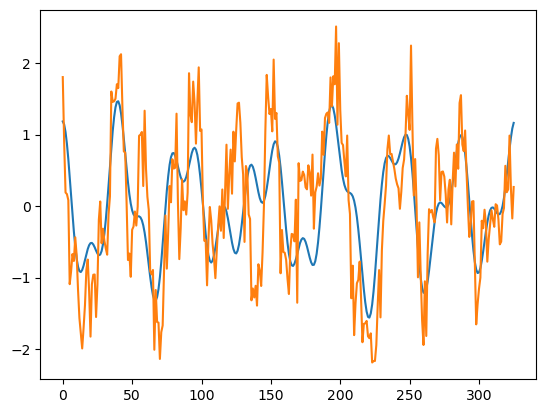

In [70]:
pd.Series(s_t).plot()
pd.Series(z_t).plot()

<Axes: >

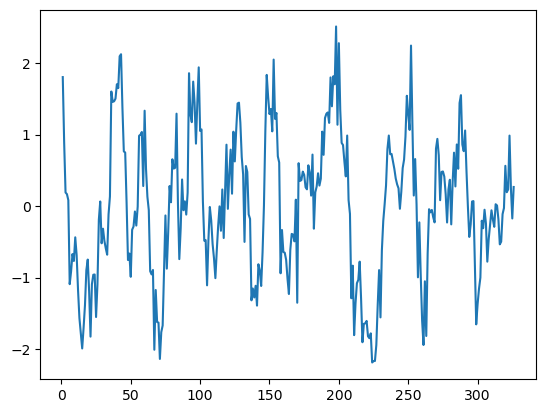

In [42]:
pd.Series(z_t).plot()

<Axes: >

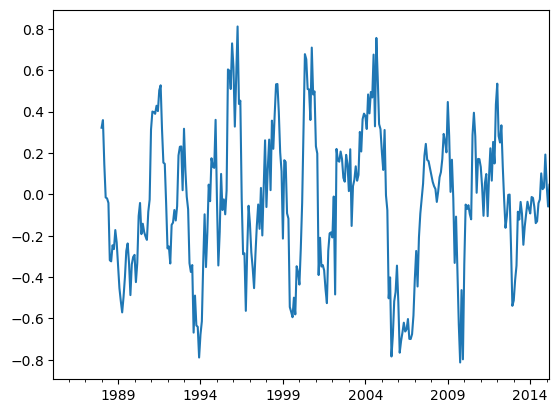

In [ ]:
x_t.plot()

n = len(x)
fhat = fft.rfft(x.values, n)
f, Pxx_den = signal.periodogram(x, 10e3, scaling='density')

# Clustering the frequency domain representation
# cat = MiniBatchKMeans(n_clusters=2, n_init="auto", init="k-means++", random_state=1234).fit(Pxx_den.reshape(-1, 1))
# filt_val = cat.cluster_centers_.flatten().argmax()
# filt_flags = cat.labels_ == filt_val

In [3]:
S = raw_signals["mom_12_1"].unstack()
last_valid_obs = S.iloc[-1].notnull()
enough_obs = S.count() > OBS_THRESH
is_valid = enough_obs & last_valid_obs  # Time series to be used to estimate the parameters
S = S.loc[:, is_valid]  # Filtered subset

In [4]:
len(is_valid)

26141

<Axes: >

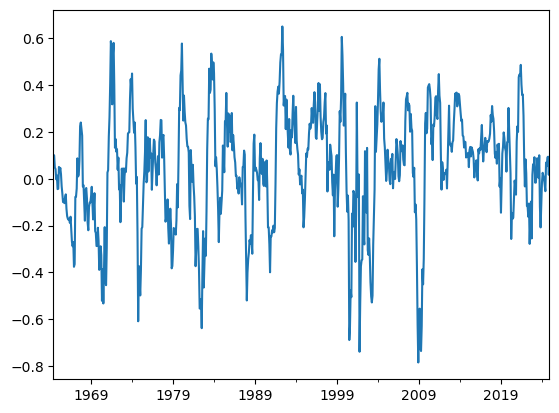

In [4]:
_id = 10145
s = S[_id].dropna()
s.plot()

In [5]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(s.to_frame())

In [6]:
# LNA
s_a = transformer.transform(s.values.reshape(-1, 1)).flatten()

<Axes: >

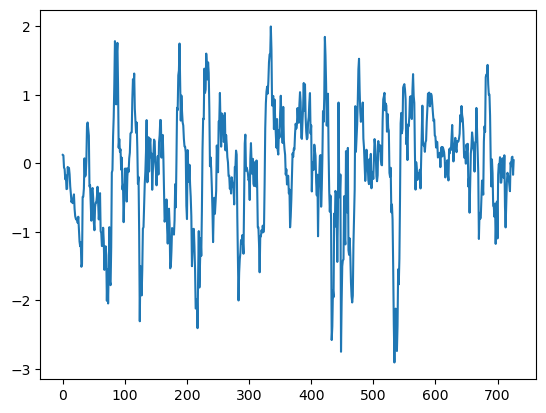

In [7]:
pd.Series(s_a).plot()